In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import shutil
shutil.copy("/content/drive/MyDrive/AI_Datasets/FER_Custom_Dataset.zip", "/content")

'/content/FER_Custom_Dataset.zip'

In [3]:
%cd /content

/content


In [4]:
import os

In [5]:
import zipfile
for file in os.listdir():
    if file.endswith(".zip"):
        with zipfile.ZipFile(file, "r") as zip_file:
            zip_file.extractall()
        os.remove(file)

In [25]:
import os
import torch
import torchvision
import tarfile
import torch.nn as nn
import numpy as np
import torch.nn.functional as F
from torchvision.datasets.utils import download_url
from torchvision.datasets import ImageFolder
from torch.utils.data import DataLoader
import torchvision.transforms as transforms
from torch.utils.data import random_split
from torchvision.utils import make_grid
import matplotlib
import seaborn as sn
import pandas as pd
from torch.utils.data import Dataset, DataLoader
import matplotlib.pyplot as plt
from torch.utils.data.sampler import SubsetRandomSampler
import glob
import torch.optim as optim
import time
import cv2
import torch
import torchvision.transforms as transforms
import torchvision.datasets as datasets
import torch.utils.data as td
import numpy as np
import matplotlib.pyplot as plt
import torch.nn as nn
import torch.nn.functional as F
from matplotlib import image
from matplotlib import pyplot
import time
import torchvision.datasets as datasets
from tqdm import tqdm
from torch.utils.tensorboard import SummaryWriter
from sklearn.metrics import confusion_matrix, classification_report
%matplotlib inline

In [8]:
PATH = '/content/FER_Custom_Dataset'
IMAGE_DIM=128
BATCH_SIZE = 32
TEST_SPLIT = 0.2
VAL_SPLIT = 0.1
N_CLASSES = 3
NUM_EPOCHS = 50
print(os.listdir(PATH))

['interested', 'Disappointed', 'neutral']


In [9]:
def load_data(path, test_split, val_split, batch_size, input_size):
    
    ######## Write your code here ########
    
    transform_dict = {
                    'src': transforms.Compose([
                      transforms.Resize(input_size),
                      transforms.RandomHorizontalFlip(), 
                      transforms.ToTensor(),
                      transforms.Normalize(mean=[0.485, 0.456, 0.406],
                                            std=[0.229, 0.224, 0.225]),
     ])}

    data = datasets.ImageFolder(root=path, transform=transform_dict['src'])
    dataset_size = len(data)

    train_size = int((1-(test_split+val_split))*dataset_size)+1
    test_size = int(test_split * dataset_size)
    val_size = int(val_split * dataset_size)
  
    train_dataset, test_dataset, val_dataset = td.random_split(data, [train_size, test_size, val_size])
    
    data_loader_train = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
    data_loader_test  = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)
    data_loader_val  = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, shuffle=True, drop_last=False, num_workers=0)

    return data_loader_train, data_loader_test, data_loader_val

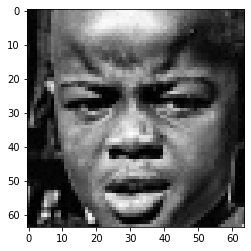

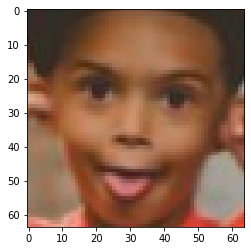

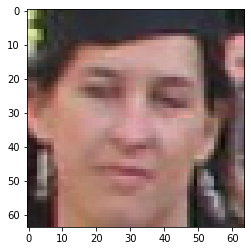

In [10]:
path = "/content/FER_Custom_Dataset"

######## Write your code here ########
InterestedImage = image.imread(path+"/Disappointed/100.jpg")
plt.figure()
plt.imshow(InterestedImage)
DisaapointedImage = image.imread(path+"/interested/253.jpg")
plt.figure()
plt.imshow(DisaapointedImage)
NeutralImage = image.imread(path+"/neutral/24634.jpg")
plt.figure()
plt.imshow(NeutralImage)

In [11]:
train_loader, test_loader, val_loader = load_data(PATH, TEST_SPLIT, VAL_SPLIT, BATCH_SIZE, IMAGE_DIM)
print("Train loader size: ",len(train_loader))
print("Test loader size: ", len(test_loader))
print("Val loader size: ", len(val_loader))

Train loader size:  91
Test loader size:  26
Val loader size:  13


In [ ]:
def plot_data_loader(data_loader, gridDims):
    
    fig, axes = plt.subplots(nrows=gridDims[0], ncols=gridDims[1], figsize=(5,5))
    dataiter = iter(data_loader)
    for i in range(gridDims[0]):
        for j in range(gridDims[1]):
            images, _ = dataiter.next()
            axes[i, j].imshow(np.transpose(images[0].numpy(), (1, 2, 0)))

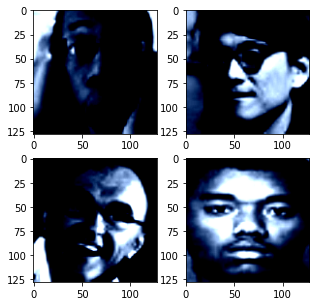

In [ ]:
plot_data_loader(train_loader, (2, 2))

In [13]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2', pretrained=False)
n_classes = 3

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)

Downloading: "https://github.com/pytorch/vision/zipball/v0.10.0" to /root/.cache/torch/hub/v0.10.0.zip
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.8/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Device: cuda:0


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

In [14]:
criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device);

Device: cuda:0


In [ ]:
for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        print(images.shape)
        #print(labels)
        if i == 5:
          break

torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])
torch.Size([32, 3, 128, 128])


In [ ]:
def evaluate(model, test_loader):
  model.eval() 
  with torch.no_grad(): 
    correct = 0
    total = 0
    for data in test_loader:
      images, labels = data[0].to(device), data[1].to(device)
      labels=torch.flatten(labels)
      outputs = model(images)
      loss = criterion(outputs, labels)
      _, predicted = torch.max(outputs.data, 1)
      total += labels.size(0)
      correct += (predicted == labels).sum().item()
  accuracy = (correct / total) * 100
  model.train()
  return accuracy, loss.item()

In [ ]:
num_epochs = 50
total_steps = len(train_loader)
t1 = time.time()

training_loss = []
training_accuracy = []
validation_loss = []
validation_accuracy = []


for epoch in range(num_epochs):
    for i, data in enumerate(train_loader):
        images, labels = data[0].to(device), data[1].to(device)
        # Forward pass
        outputs = model(images)
        loss = criterion(outputs, labels)
        # Backprop and optimisation
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        # Train accuracy
        total = labels.size(0)
        _,predicted = torch.max(outputs.data, 1)
        correct = (predicted == labels).sum().item()
        if (i + 1) % 100 == 0:
            val_accu, val_loss = evaluate(model, test_loader)
            print('Epoch [{}/{}], Step [{}/{}], Loss: {:.4f}, Accuracy: {:.2f}, val_loss: {:.4f}, val_accuracy: {:.2f}%'.format(epoch + 1, num_epochs, i + 1, total_steps, loss.item(),(correct / total) * 100, val_loss, val_accu))
            training_loss.append(loss.item())
            training_accuracy.append((correct / total) * 100)
            validation_accuracy.append(val_accu)
            validation_loss.append(val_loss)
            
print("######## Training Finished in {} seconds ###########".format(time.time()-t1))


Epoch [1/50], Step [100/104], Loss: 1.0441, Accuracy: 53.12, val_loss: 1.1708, val_accuracy: 49.22%
Epoch [2/50], Step [100/104], Loss: 1.0800, Accuracy: 46.88, val_loss: 1.0118, val_accuracy: 51.03%
Epoch [3/50], Step [100/104], Loss: 1.0027, Accuracy: 46.88, val_loss: 0.9827, val_accuracy: 53.08%
Epoch [4/50], Step [100/104], Loss: 1.0909, Accuracy: 37.50, val_loss: 0.8705, val_accuracy: 51.03%
Epoch [5/50], Step [100/104], Loss: 1.0093, Accuracy: 46.88, val_loss: 0.8818, val_accuracy: 49.82%
Epoch [6/50], Step [100/104], Loss: 0.8720, Accuracy: 65.62, val_loss: 1.1694, val_accuracy: 46.68%
Epoch [7/50], Step [100/104], Loss: 1.2411, Accuracy: 31.25, val_loss: 1.1667, val_accuracy: 50.54%
Epoch [8/50], Step [100/104], Loss: 1.0463, Accuracy: 50.00, val_loss: 1.0239, val_accuracy: 52.71%
Epoch [9/50], Step [100/104], Loss: 0.8877, Accuracy: 59.38, val_loss: 0.9148, val_accuracy: 53.08%
Epoch [10/50], Step [100/104], Loss: 1.0210, Accuracy: 43.75, val_loss: 0.9831, val_accuracy: 53.44%

# Save Model

In [ ]:
PATH = "/content/drive/MyDrive/AI_Datasets/MobileNet_ferCustom.pt"
torch.save(model.state_dict(), PATH)

# Load Model

In [15]:
model = torch.hub.load('pytorch/vision:v0.10.0', 'mobilenet_v2')

model.load_state_dict(torch.load('/content/drive/MyDrive/AI_Datasets/MobileNet_ferCustom.pt'))

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("Device: {}".format(device))
model.to(device)

model.eval()

Using cache found in /root/.cache/torch/hub/pytorch_vision_v0.10.0


Device: cuda:0


MobileNetV2(
  (features): Sequential(
    (0): Conv2dNormActivation(
      (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1), bias=False)
      (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (2): ReLU6(inplace=True)
    )
    (1): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(32, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), groups=32, bias=False)
          (1): BatchNorm2d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (2): ReLU6(inplace=True)
        )
        (1): Conv2d(32, 16, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (2): BatchNorm2d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      )
    )
    (2): InvertedResidual(
      (conv): Sequential(
        (0): Conv2dNormActivation(
          (0): Conv2d(16, 96, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (1): BatchNorm2d(96, eps=

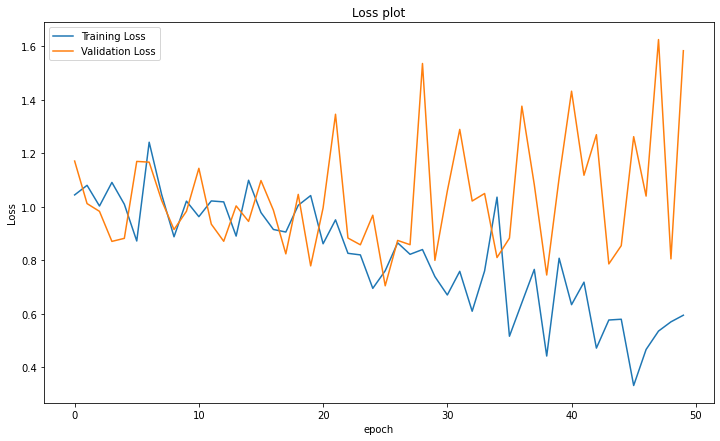

In [ ]:
epochs = [i for i in range(num_epochs)]
plt.figure(figsize = (12,7))
plt.xlabel('epoch')
plt.ylabel('Loss')
plt.title('Loss plot')

plt.plot(epochs,training_loss,label='Training Loss')
plt.plot(epochs,validation_loss,label='Validation Loss')

plt.legend()
plt.savefig('Loss_MobileNet_FER.png')

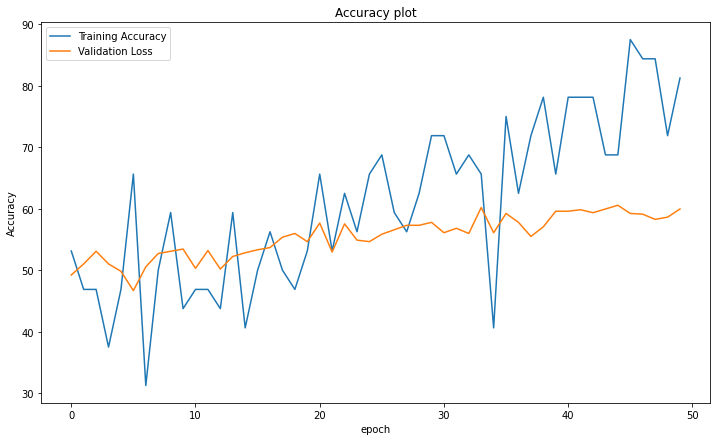

In [ ]:
epochs = [i for i in range(num_epochs)]
plt.figure(figsize = (12,7))
plt.xlabel('epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy plot')

plt.plot(epochs,training_accuracy,label='Training Accuracy') 
plt.plot(epochs,validation_accuracy,label='Validation Loss')

plt.legend()
plt.savefig('Accuracy_MobileNet_FER.png')

In [26]:
def confusion_matrix_for_specific_LR(model, test_loader):
    y_pred = []
    y_true = []
    for i, data in enumerate(test_loader):
        
        inputs, labels = data[0].to(device), data[1].to(device)
        output = model(inputs) # Feed Network
        
        output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
        y_pred.extend(output) # Save Prediction
        labels = labels.data.cpu().numpy()
        y_true.extend(labels) # Save Truth

    # constant for classes
    classes = ('neutral', 'interested', 'Disappointed')

    # Build confusion matrix
    cf_matrix = confusion_matrix(y_true, y_pred)

    import seaborn as sns

    # sns.heatmap(cf_matrix, annot=True)
    df_cm = pd.DataFrame(cf_matrix, index = [i for i in classes],
                         columns = [i for i in classes])
    plt.figure(figsize = (12,7))
    sn.heatmap(df_cm, annot=True)
    plt.savefig(f'Confusion_matrix_MobileNet_Fer.png')
    print(classification_report(y_true, y_pred, target_names=['interested', 'Disappointed', 'neutral']))

              precision    recall  f1-score   support

  interested       0.84      0.80      0.82       288
Disappointed       0.82      0.77      0.79       231
     neutral       0.78      0.86      0.82       310

    accuracy                           0.81       829
   macro avg       0.81      0.81      0.81       829
weighted avg       0.81      0.81      0.81       829



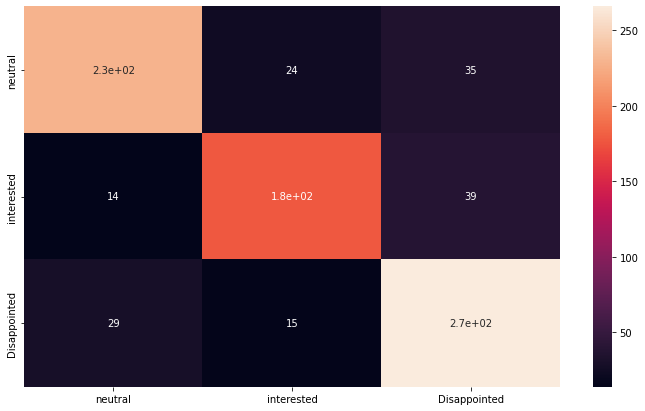

In [27]:
confusion_matrix_for_specific_LR(model, test_loader)